## Tempe Rapid Testing
###### Code by Drew Gobbi - 02/01/2020

### Import Packages and Data Cleaning

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import strptime
import os 
import patsy 
from shapely.wkt import loads
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle

In [ ]:
#tempe ems 
eurl = 'https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/Opioid_Calls/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
tempems = gpd.read_file(eurl)
tempems.to_csv('tempems.csv')

In [ ]:
tempems.head()

In [ ]:
tempems.dtypes

In [ ]:
tempems = tempems[tempems['Opioid_Use'] == 'Yes']

In [ ]:
tempems.shape

In [ ]:
tempems.head()

In [ ]:
#city planning data
tempe = gpd.read_file("https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/Map/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token=")

In [ ]:
tempe.head()

In [ ]:
tempems['Month'] = tempems['Month'].apply(lambda x: strptime(x,'%B').tm_mon)
tempems["date"] = tempems["Year"].map(str) + '-' + tempems["Month"].map(str)
tempems["date"] = pd.to_datetime(tempems["date"])

In [ ]:
tempems.shape

In [ ]:
tempe_tract = pd.DataFrame()
for i in range(len(tempe)):
    df = tempems[tempems.within(tempe.loc[i,'geometry'])]
    df['tract'] = tempe.loc[i,'TempeTracts_NAME']
    tempe_tract = pd.concat([tempe_tract, df], axis=0)

In [ ]:
tempe_tract.head()

In [ ]:
tempe_tract.shape

In [ ]:
tempe.plot()

In [ ]:
tempe_tract = tempe_tract.merge(tempe, left_on='tract', right_on='TempeTracts_NAME')

In [ ]:
tempe_tract.drop('geometry_y', inplace=True, axis=1)

In [ ]:
tempe_tract.rename(columns={'geometry_x':'geometry'}, inplace=True)
tempe_tract = gpd.GeoDataFrame(tempe_tract, geometry=tempe_tract.geometry)

In [ ]:
tempe_tract.shape

In [ ]:
tempe_tract.head()

In [ ]:
tempe_tract.date?

In [ ]:
tempe_tract.tract = tempe_tract.tract.astype(float)

In [ ]:
len(tempe_tract.tract.unique())

In [ ]:
tempe_tract.date.dt.year.unique()

In [ ]:
tempe_tract['month_year'] = tempe_tract.date.dt.year.astype(float) + tempe_tract.date.dt.month.astype(float)/100

In [ ]:
tempe_tract.month_year.head()

In [ ]:
op = tempe_tract.filter(['tract', 'month_year', 'Opioid_Use'])

In [ ]:
op.head()

In [ ]:
op = op.groupby(by=[op['tract'], op['month_year']]).count()

In [ ]:
op.reset_index(inplace=True)

In [ ]:
tempe_tract = tempe_tract.groupby(by=[tempe_tract['tract'], tempe_tract['month_year']]).mean()

In [ ]:
tempe_tract.reset_index(inplace=True)

In [ ]:
df = tempe_tract.merge(op, on=['tract', 'month_year'])

In [ ]:
sum(df.Opioid_Use)

In [ ]:
df.head()

In [ ]:
tempe_fac = pd.read_csv('TEMPEcntMedicalFacilitiesWithin2milesByTract.csv')

In [ ]:
tempe_fac.dtypes

In [ ]:
df = df.merge(tempe_fac, left_on='tract', right_on='TempeTracts_Name')

In [ ]:
df.head()

In [ ]:
df['ems_flag'] = 0 
for i in range(len(df)):
    if df['Opioid_Use'][i] >np.median(df['Opioid_Use']):
        df['ems_flag'][i] =1

In [ ]:
df['ems_flag'].value_counts()

In [ ]:
sum(df['Opioid_Use'])

In [ ]:
df.rename({'Opioid_Use' : 'ems_calls'}, inplace=True)

In [ ]:
from shapely import wkt

df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry=df['geometry'])

In [ ]:
df.boundary.plot()

In [ ]:
pickle_out = open("tempems_pkl","wb")
pickle.dump(df, pickle_out)
pickle_out.close()

In [ ]:
df.rename(columns={'Opioid_Use': 'ems_calls'}, inplace=True)

In [ ]:
df.ems_calls.hist()

In [ ]:
df.ems_calls.describe()

### Data Exploration

In [2]:
pkl_in_temp = open('tempems_pkl', 'rb')

df = pickle.load(pkl_in_temp)

In [3]:
df.rename(columns={'Opioid_Use': 'ems_calls'}, inplace=True)

### EMS Poisson Regression

In [ ]:
v = ['pdb2018trv4_us_csv_Med_HHD_Inc_', 
'pdb2018trv4_us_csv_pct_Males_AC',
'pdb2018trv4_us_csv_pct_Pop_18_2',
'pdb2018trv4_us_csv_pct_Pop_25_4',
'pdb2018trv4_us_csv_pct_College_',
'ems_calls',
'year_month',
'TempeTracts_NAME', 
'HospitalsGeneralCount2mi',
'HospitalsPsychCount2mi',
'SurgicalCentersCount2mi',
'UrgentCareCount2mi',
'WomensClinicsCount2mi',
'PainManagementCount2mi',
'PhysicalTherapyCount2mi',
'MentalFacilitiesCount2mi',
'SubstanceAbuseCount2mi',
'OtherMedicalFacilitesCount2mi',
'NursingAssistedLiveCount2mi',
'HospiceCount2mi',
'ChildFacilitiesCount2mi',
'PharmCount2mi',
'DrugDropCount2mi',
'NaloxoneDistribCount2mi',]

In [ ]:
df = df.filter(v)

In [ ]:
X, y = df, df.ems_calls
#X.drop('ems_flag', inplace=True, axis=1)
X.drop('ems_calls', inplace=True, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#run model 
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
res.summary()

#get predictions
poisson_predictions = res.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()
predictions_summary_frame.head()

In [ ]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test
fig = plt.figure(figsize=(10,10))
fig.title('Tempe Predicted versus actual EMS calls')
predicted, = plt.plot(predicted_counts, 'go', label='Predicted counts')
actual, = plt.plot(actual_counts, 'ro', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#### Try PCA

In [4]:
from sklearn.decomposition import PCA

In [5]:
df2 = df
df2 = df2.select_dtypes(include=['float64', 'int64'])

In [6]:
df2.shape

(440, 484)

In [7]:
df2.replace(np.NaN, 0, inplace=True)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [8]:
X, y = df2, df2.ems_calls
#X.drop('ems_flag', inplace=True, axis=1)
X.drop('ems_calls', inplace=True, axis=1)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_train)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [11]:
# Make an instance of the Model
pca = PCA(.95)

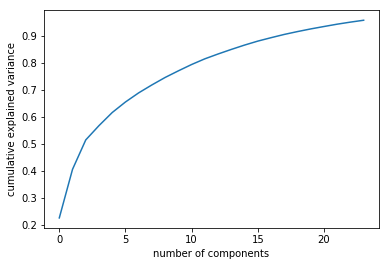

In [12]:
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [13]:
pca.n_components_

24

In [14]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [25]:
#run model 
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              ems_calls   No. Observations:                  352
Model:                            GLM   Df Residuals:                      328
Model Family:                 Poisson   Df Model:                           23
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -482.56
Date:                Tue, 04 Feb 2020   Deviance:                       165.34
Time:                        20:29:03   Pearson chi2:                     226.
No. Iterations:                     4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0007      0.005      0.130      0.897      -0.009       0.011
x2            -0.0155      0.006     -2.461      0.0

In [ ]:
#X2, X4, X5 apear to be statistically significant 
## TO DO - Factor Analysis/Loadings 
## To DO - Get Predictions (how to transform y var)

### EMS Classification

In [ ]:
df = df.select_dtypes(include=['float64', 'int', 'bool'])

In [ ]:
df.replace(np.NaN, 0, inplace=True)

In [ ]:
X, y = df, df.ems_flag
X.drop('ems_flag', inplace=True, axis=1)
X.drop('ems_calls', inplace=True, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as lr 

selector = SelectFromModel(estimator=lr()).fit(X_train, y_train)

feature_index = selector.get_support()
feature_names = df.columns[feature_index]
feature_names


In [ ]:
### Use Model Selected Variables --- Weird Results? 
var_test = ['TempeTracts_ALAND', 'TempeTracts_GeoTrack', 'pdb2018trv4_us_csv_GIDTR',
       'pdb2018trv4_us_csv_Aggregate_HH', 'pdb2018trv4_us_csv_Aggregate__1',
       'pdb2018trv4_us_csv_Aggr_House_V', 'pdb2018trv4_us_csv_Aggr_House_1',
       'Shape__Area',]

Xlr = X.filter(var_test)

In [ ]:
X_train2, X_test2 = Xlr[:352], Xlr[352:]

In [ ]:
clf = lr().fit(X_train2, y_train)
pred = clf.predict(X_test2)

In [ ]:
print(classification_report(y_test, pred))

In [ ]:
confusion_matrix(y_test, pred)

In [ ]:
#### Try Own Selected Variables
var = ['pdb2018trv4_us_csv_Med_HHD_Inc_', 'pdb2018trv4_us_csv_pct_College_', 'pdb2018trv4_us_csv_pct_Pop_18_2',
'pdb2018trv4_us_csv_pct_Pop_45_6', 'pdb2018trv4_us_csv_pct_Males_AC', 'pdb2018trv4_us_csv_pct_Civ_unem']

In [ ]:
Xlr2 = X.filter(var)
X_train3, X_test3 = Xlr2[:352], Xlr2[352:]

In [ ]:
clf = lr().fit(X_train3, y_train)
pred = clf.predict(X_test3)

In [ ]:
print(classification_report(y_test, pred))
confusion_matrix(y_test, pred)

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)

rf_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, rf_pred))
print(confusion_matrix(y_test, rf_pred))

In [ ]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [ ]:
#top 5 features - is RF just not learning anything?
fi.head()

In [ ]:
# Fit on training data
model.fit(X_train3, y_train)

rf_pred = model.predict(X_test3)

In [ ]:
print(classification_report(y_test, rf_pred))
confusion_matrix(y_test, rf_pred)

### Water Data

In [ ]:
wa = gpd.read_file('https://services.arcgis.com/lQySeXwbBg53XWDi/ArcGIS/rest/services/Wastewater_Study_Areas/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token=')


In [ ]:
wa.plot()